### Import modules

In [1]:
from pyspark.sql.functions import isnull, when, count, col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

### Setting up connection parameters

In [2]:
uri_db = 'mongodb+srv://<username>:<password>@bigdata.toqh2.mongodb.net'
spark_connector_uri = 'org.mongodb.spark:mongo-spark-connector_2.11:2.2.7'

In [3]:
# Create a SparkSession object.
session = SparkSession.builder \
    .master('local') \
    .config('spark.mongodb.input.uri', uri_db) \
    .config('spark.jars.packages', spark_connector_uri) \
    .getOrCreate()

# Get context from SparkSession object.
context = session.sparkContext

### Data retrieving

In [4]:
# Read data from MongoDB and return two DataFrame objects, one
# for each collection contained in database.
df_reviews = session.read \
    .format('com.mongodb.spark.sql.DefaultSource') \
    .option('database', 'test') \
    .option('collection', 'reviews') \
    .load()
df_meta = session.read \
    .format('com.mongodb.spark.sql.DefaultSource') \
    .option('database', 'test') \
    .option('collection', 'meta') \
    .load()

# Print collections schemas.
df_reviews.printSchema()
df_meta.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 | 

### Data preparation

#### Common

In [5]:
# Drop MongoDB _id column.
df_reviews = df_reviews.drop('_id')
df_meta = df_meta.drop('_id')

#### Reviews

In [6]:
def get_helpful_rate(array):
    '''
        Compute the fraction of users that found the review helpful.

        Args:
            array (array): two elements array.
                
            E.g. [1, 2], one found the review helpful over a total of two.

        Returns:
            float: percentage of user that found the review helpful.
    '''
    num = array[0]
    den = array[1]
    res = 0

    if den != 0:
        res = num/den * 100
        
    return float(res)

# Create helpful_rate and helpful_pos columns from helpful column.
df_reviews = df_reviews.rdd \
    .map(lambda x: x + (get_helpful_rate(x['helpful']), x['helpful'][0], )) \
    .toDF(df_reviews.columns + ['helpful_rate', 'helpful_pos']) \
    .drop('helpful')

#### Meta

In [7]:
# Create sales_rank_sports_etc columns from salesRank column.
df_meta = df_meta \
    .join(df_meta.select(['asin', 'salesRank.Sports &amp; Outdoors']), on='asin') \
    .drop('salesRank') \
    .withColumnRenamed('Sports &amp; Outdoors', 'sales_rank_sports_etc')

# Drop categories, related and imUrl columns.
df_meta = df_meta \
    .drop('categories', 'related', 'imUrl')

# Count null values per column.
print('(Pre-cleaning) Null values per column: ')
df_meta.select([count(when(isnull(c), c)).alias(c) for c in df_meta.columns]).show()

# Fill price null values or NaNs with the mean value of the price column.
df_meta = df_meta.na.fill({'price': df_meta.dropna(subset=['price']).agg(avg('price')).first()[0]})
# Fill sales_rank_sports_etc null values with the mean value of the sales_rank_sports_etc column.
df_meta = df_meta.na.fill({'sales_rank_sports_etc': df_meta.dropna(subset=['sales_rank_sports_etc']).agg(avg('sales_rank_sports_etc')).first()[0]})
# Fill brand null values or empty strings with 'No Brand'.
df_meta = df_meta \
    .withColumn('brand', when(col('brand') != '', col('brand')).otherwise(None))
df_meta = df_meta.na.fill({'brand': 'No Brand'})
# Fill title empty strings with 'No Title'
df_meta = df_meta \
    .withColumn('title', when(col('title') != '', col('title')).otherwise(None))
df_meta = df_meta.na.fill({'title': 'No Title'})
# Fill description empty strings with 'No Description'.
df_meta = df_meta \
    .withColumn('description', when(col('description') != '', col('description')).otherwise(None))
df_meta = df_meta.na.fill({'description': 'No Description'})

print('(Post-cleaning) Null values per column: ')
df_meta.select([count(when(isnull(c), c)).alias(c) for c in df_meta.columns]).show()

brand_categorical = {}
index_categorical = 1
def map_brand_to_categorical(brand):
    '''
        Map brand's name to categorical.

        Args:
            brand (string): brand's name.
        Returns:
            int: categorical value.
    '''
    global brand_categorical
    global index_categorical

    if brand not in brand_categorical.keys():
        brand_categorical[brand] = index_categorical
        index_categorical += 1

    return brand_categorical[brand]

# Map brand's name to categorical.
brands = df_meta.select('brand').rdd.map(lambda x: x[0]).collect()
cat = [map_brand_to_categorical(brand) for brand in brands]

df_meta = df_meta.rdd \
    .map(lambda x: x + (brand_categorical[x['brand']], )) \
    .toDF(df_meta.columns + ['brand_cat'])

(Pre-cleaning) Null values per column: 
+----+-----+-----------+-----+-----+---------------------+
|asin|brand|description|price|title|sales_rank_sports_etc|
+----+-----+-----------+-----+-----+---------------------+
|   0|  603|        133|  361|   24|                  539|
+----+-----+-----------+-----+-----+---------------------+

(Post-cleaning) Null values per column: 
+----+-----+-----------+-----+-----+---------------------+
|asin|brand|description|price|title|sales_rank_sports_etc|
+----+-----+-----------+-----+-----+---------------------+
|   0|    0|          0|    0|    0|                    0|
+----+-----+-----------+-----+-----+---------------------+



### Queries

In [8]:
# Query #1
df_1 = df_reviews \
    .groupby('asin') \
    .count() \
    .withColumnRenamed('count', 'reviews_count_product') \
    .orderBy('reviews_count_product', ascending=False)

print("# I 100 prodotti con il maggior numero di recensioni #")
df_1.show(100)

# I 100 prodotti con il maggior numero di recensioni #
+----------+---------------------+
|      asin|reviews_count_product|
+----------+---------------------+
|B0000533G7|                 2239|
|7245456313|                 2033|
|B00004YVAJ|                 1503|
|B00005MOYK|                 1500|
|B00005UOSC|                  560|
|B000067Q0P|                  459|
|B0000644AF|                  401|
|B00005RCQS|                  381|
|B00004SQM9|                  376|
|B000067QMK|                  357|
|B00004TXM7|                  347|
|B0000789T2|                  339|
|B00005UDHY|                  318|
|B00005LDW4|                  308|
|B00005K416|                  295|
|B0000643KA|                  290|
|B00000IUX5|                  279|
|B00006WNPY|                  253|
|B00005JD40|                  246|
|B00006JHVN|                  240|
|B00005BAIB|                  234|
|B00005OU9D|                  230|
|B00004THDC|                  229|
|B00005NPPQ|                  214|


In [9]:
# Query #2
df_2 = df_reviews \
    .groupby('reviewerID') \
    .count() \
    .withColumnRenamed('count', 'reviews_count_reviewer') \
    .orderBy('reviews_count_reviewer', ascending=False)

print("# I 100 reviewer che hanno effettuato il maggior numero di recensioni #")
df_2.show(100)

# I 100 reviewer che hanno effettuato il maggior numero di recensioni #
+--------------+----------------------+
|    reviewerID|reviews_count_reviewer|
+--------------+----------------------+
| AF3EVH5OFWIQN|                    16|
| AVOGV98AYOFG2|                    14|
| AQUHJVX6O882V|                    12|
| AFP4UF1P3UX7U|                     9|
|A1M2T0J45TTE64|                     8|
|A1BG8QW55XHN6U|                     6|
|A2XGLU92QG2B6B|                     5|
|A3T64QUILPVD2M|                     5|
|A31PDR78F1MNDI|                     5|
|A281NPSIMI1C2R|                     4|
|A1Y24I34B8Z2SO|                     4|
|A3OXHLG6DIBRW8|                     3|
|A21CR6QBS7CAFR|                     3|
|A1GPG0YXH9QD9S|                     3|
|A3FOOF7Q2GUMXX|                     3|
| AZJB0HAT6GLHZ|                     3|
|A2IFY6958MRGEM|                     3|
|A2WLNSZ9U0T1S3|                     3|
| AHRQOLXJE4CBV|                     3|
|A1MJZAV7WH0LC7|                     3|
|A15JLMD

In [10]:
# Query #3
df_3 = df_reviews \
    .join(df_meta, on='asin') \
    .filter("brand != 'No Brand'") \
    .groupBy('brand') \
    .count() \
    .withColumnRenamed('count', 'reviews_count_brand') \
    .orderBy('reviews_count_brand', ascending=False)

print("# Le 50 marche i cui prodotti sono stati maggiormente recensiti #")
df_3.show(50)

# Le 50 marche i cui prodotti sono stati maggiormente recensiti #
+--------------------+-------------------+
|               brand|reviews_count_brand|
+--------------------+-------------------+
|          Victorinox|               2566|
|         Dr. Bronner|               2239|
|      Black Mountain|               2189|
|               Razor|               1603|
|             Coleman|                933|
|         Radio Flyer|                634|
|               Intex|                593|
|        Fisher-Price|                560|
|             Aerobie|                521|
|             Airzone|                459|
|         Master Lock|                422|
|  PACIFIC PLAY TENTS|                416|
|              Speedo|                406|
|             Thermos|                401|
|            Franklin|                364|
|            Mongoose|                357|
|SOG Specialty Knives|                351|
|             Stanley|                349|
|       Gerber Blades|         

In [11]:
# Query #4
df_4 =  df_reviews \
     .join(df_meta, on='asin') \
     .select(['brand', 'price']) \
     .filter("brand != 'No Brand'") \
     .groupby('brand') \
     .mean() \
     .withColumnRenamed('avg(price)', 'price_mean') \
     .orderBy('price_mean', ascending=False)

print("# Le 50 marche i cui prodotti hanno un prezzo medio maggiore #")
df_4.show(50)

# Le 50 marche i cui prodotti hanno un prezzo medio maggiore #
+--------------------+------------------+
|               brand|        price_mean|
+--------------------+------------------+
|           Celestron|            454.95|
|               Canon| 399.8899999999995|
|        Title Boxing|            317.12|
|               Viper|            209.99|
|            Bushnell|165.77392857142846|
|                Tomy| 126.9399999999999|
|MAPTECH PAPER CHARTS|            116.95|
|            Rawlings|116.20772727272724|
|          Super Pogo|108.98999999999984|
|          Tripp Lite|107.45000000000002|
|              Suunto|101.71142857142857|
|        Allen Sports| 99.96999999999974|
|   Chef&#39;s Choice| 99.94999999999989|
|        Fisher-Price| 95.19999999999919|
|             Maptech| 86.65871403812825|
|             Coleman| 85.65457663451235|
|       STOTT PILATES|  75.7722616984402|
|             Generic| 73.62190463493756|
|      Flexible Flyer| 69.94999999999996|
|         Tia

In [12]:
# Query #5
df_5 = df_reviews \
    .select(['asin', 'overall']) \
    .groupby('asin') \
    .mean() \
    .withColumnRenamed('avg(overall)', 'overall_mean_product')

# Join to df_1 in order to obtain reviews_count_product column.
df_5 = df_5 \
    .join(df_1, on='asin') \
    .orderBy(['overall_mean_product', 'reviews_count_product'], ascending=False)

print("# I 100 prodotti con le migliori recensioni #")
df_5.show(100)

# I 100 prodotti con le migliori recensioni #
+----------+--------------------+---------------------+
|      asin|overall_mean_product|reviews_count_product|
+----------+--------------------+---------------------+
|1300966955|                 5.0|                    9|
|0615302939|                 5.0|                    9|
|B00000201L|                 5.0|                    8|
|1553602056|                 5.0|                    7|
|B00006JK2H|                 5.0|                    7|
|1304046176|                 5.0|                    7|
|1300310065|                 5.0|                    6|
|B00006IB76|                 5.0|                    6|
|1304801675|                 5.0|                    6|
|724545647X|                 5.0|                    6|
|1300966947|                 5.0|                    6|
|7245456550|                 5.0|                    5|
|1304802035|                 5.0|                    5|
|B00004WFUA|                 5.0|                    5|
|1

In [13]:
# Query #6
df_6 = df_reviews \
    .join(df_meta, on='asin') \
    .select(['brand', 'overall']) \
    .filter("brand != 'No Brand'") \
    .groupBy('brand') \
    .mean() \
    .withColumnRenamed('avg(overall)', 'overall_mean_brand')

# Join to df_1 in order to obtain reviews_count_brand column.
df_6 = df_6 \
    .join(df_3, on='brand') \
    .orderBy(['overall_mean_brand', 'reviews_count_brand'], ascending=False)

print("# Le 100 marche con le migliori recensioni #")
df_6.show(100)

# Le 100 marche con le migliori recensioni #
+--------------------+------------------+-------------------+
|               brand|overall_mean_brand|reviews_count_brand|
+--------------------+------------------+-------------------+
|                 NNG|               5.0|                  9|
|  APBA International|               5.0|                  3|
|            Titanium|               5.0|                  3|
|   Football Fanatics|               5.0|                  2|
|MAPTECH PAPER CHARTS|               5.0|                  2|
|Beartooth Publishing|               5.0|                  1|
|            BD&amp;A|               5.0|                  1|
|     NBA Sportspicks|               5.0|                  1|
|  Paddlesports Press|               5.0|                  1|
|       Power Systems|               5.0|                  1|
|            Pavilion|               5.0|                  1|
|       Logo Athletic|               5.0|                  1|
|    Late for the Sky|   

In [14]:
# Query #7
df_mean = df_reviews \
    .select(['reviewerID', 'helpful_rate']) \
    .groupBy('reviewerID') \
    .mean('helpful_rate') \
    .withColumnRenamed('avg(helpful_rate)', 'helpful_rate_mean')
    
df_sum = df_reviews \
    .select(['reviewerID', 'helpful_pos']) \
    .filter('helpful_pos != 0') \
    .groupBy('reviewerID') \
    .sum() \
    .withColumnRenamed('sum(helpful_pos)', 'helpful_pos_sum')

df_7 = df_mean \
    .join(df_sum, on='reviewerID') \
    .orderBy(['helpful_rate_mean', 'helpful_pos_sum'], ascending=False)
    
print("# I 100 reviewer che hanno effettuato recensioni con la maggiore utilità media #")
df_7.show(100)

# I 100 reviewer che hanno effettuato recensioni con la maggiore utilità media #
+--------------+-----------------+---------------+
|    reviewerID|helpful_rate_mean|helpful_pos_sum|
+--------------+-----------------+---------------+
| A754P3SA07347|            100.0|            414|
| AGVMN9XEO8WHE|            100.0|            155|
|A1CIU06M0GZNHA|            100.0|            133|
| AW33RDB2CET4O|            100.0|            127|
| AU7O296O6PXZM|            100.0|            100|
|A2LXYB1QS1GE2R|            100.0|             89|
|A272YYWDRJJFXN|            100.0|             88|
|A1C1NWYHIC0P5Q|            100.0|             84|
| A66USRPEQF5EM|            100.0|             78|
|A37TFIP0OMKGMW|            100.0|             76|
|  A6FIAB28IS79|            100.0|             73|
|A2JRF895NK97WF|            100.0|             63|
|A23ZFVBVURH1K1|            100.0|             62|
| A1VV0GG88Y0JA|            100.0|             59|
|A3EUWX2K4H2O5F|            100.0|             58|
|

In [15]:
# Query #9
df_9 = df_meta \
    .orderBy('sales_rank_sports_etc', ascending=True) \
    .select(['asin', 'sales_rank_sports_etc'])

print('# I 100 prodotti con il migliore ranking nelle vendite #')
df_9.show(100)

# I 100 prodotti con il migliore ranking nelle vendite #
+----------+---------------------+
|      asin|sales_rank_sports_etc|
+----------+---------------------+
|7245456313|                   15|
|B00004YVB3|                   49|
|B00004YVB2|                   49|
|B00004YVAJ|                   49|
|B00005UDHY|                   88|
|B00005UDHZ|                   88|
|B000067QMK|                   94|
|B00005BHNT|                  142|
|B00005BHO0|                  142|
|B00005BHNZ|                  142|
|B00005LDW4|                  151|
|B000051ZHS|                  262|
|B00005BAIB|                  546|
|B00005RCQS|                  601|
|B00004NKIQ|                  856|
|B000068CJZ|                  958|
|7245456267|                 1010|
|7245456283|                 1010|
|7245456259|                 1010|
|7245456275|                 1010|
|B00005QEZF|                 1109|
|B00005MOYK|                 1145|
|B000071K5K|                 1148|
|B00004T11T|                 1465

In [16]:
# Query #10
df_10 = df_meta \
    .select(['brand', 'sales_rank_sports_etc']) \
    .filter("brand != 'No Brand'") \
    .groupby('brand') \
    .mean() \
    .withColumnRenamed('avg(sales_rank_sports_etc)', 'sales_rank_sports_etc_mean') \
    .orderBy(['sales_rank_sports_etc_mean'], ascending=True)

print('# Le 50 marche i cui prodotti hanno il ranking medio migliore #')
df_10.show(50)

# Le 50 marche i cui prodotti hanno il ranking medio migliore #
+--------------------+--------------------------+
|               brand|sales_rank_sports_etc_mean|
+--------------------+--------------------------+
|            Mongoose|                      94.0|
|               Razor|                    1375.5|
|            Spalding|                    7681.0|
|              Carrom|                   10603.0|
|      Black Mountain|        10638.285714285714|
|            Lifetime|                   11131.0|
|          Booklegger|                   17089.0|
|              Speedo|                   17226.6|
|Rubbermaid Commer...|                   20091.0|
|            The Club|                   23625.0|
|              Outers|                   26597.5|
|          Golf Smart|                   27809.0|
|               Koosh|                   31211.0|
|                 NHL|                   34073.0|
|          Star Brite|                   57761.0|
|          Super Pogo|              

### Correlations

#### Single Coefficients

In [28]:
def get_corr_coef(df, first_c, second_c):
    '''
        Compute correlation coeff between two columns of the same DataFrame.
        
        Args:
            df (DataFrame): DataFrame object;
            first_c (string): name of the first column;
            second_c (string): name of the second column.
            
            N.B. DataFrame column must be numeric.
        Returns:
            (float): computed corr coeff.
    '''
    mat = np.array(df.select(first_c, second_c).collect()).astype(np.float)

    return np.corrcoef(mat[:, 0], mat[:, 1])[0, 1]
    
df_reviews_sub = df_reviews \
    .drop('reviewText', 'reviewTime', 'reviewerName', 'summary')

df_meta_sub = df_meta \
    .drop('brand', 'description', 'title')

df_result = df_reviews_sub \
    .join(df_meta_sub, on='asin') \
    .join(df_1, on='asin') \
    .join(df_5.drop('reviews_count_product'), on='asin') \
    .drop('asin', 'reviewerID')

print('# Correlazione tra il prezzo di un prodotto e il punteggio medio ottenuto nelle recensioni #')
cc1 = get_corr_coef(df_result, 'price', 'overall_mean_product')
print(cc1)

print('# Correlazione tra la marca di un prodotto e il punteggio medio ottenuto nelle recensioni #')
cc2 = get_corr_coef(df_result, 'brand_cat', 'overall_mean_product')
print(cc2)

print("# Correlazione tra l'utilità di una recensione e il punteggio assegnato dalla recensione al prodotto #")
cc3 = get_corr_coef(df_result, 'helpful_rate', 'overall')
print(cc3)

print('# Correlazione tra la data di una recensione e l’utilità della stessa #')
cc4 = get_corr_coef(df_result, 'unixReviewTime', 'helpful_rate')
print(cc4)

print('# Correlazione tra la data di una recensione e il punteggio assegnato al prodotto #')
cc5 = get_corr_coef(df_result, 'unixReviewTime', 'overall')
print(cc5)

print('# Correlazione tra il ranking delle vendite di un prodotto e i punteggi ottenuti nelle recensioni #')
cc6 = get_corr_coef(df_result, 'sales_rank_sports_etc', 'overall_mean_product')
print(cc6)

print('# Correlazione tra il numero delle recensioni di un prodotto e il ranking nelle vendite #')
cc7 = get_corr_coef(df_result, 'reviews_count_product', 'sales_rank_sports_etc')
print(cc7)

print('# Correlazione tra il ranking nelle vendite e il prezzo #')
cc8 = get_corr_coef(df_result, 'sales_rank_sports_etc', 'price')
print(cc8)

# Correlazione tra il prezzo di un prodotto e il punteggio medio ottenuto nelle recensioni #
-0.0034833598856055187
# Correlazione tra la marca di un prodotto e il punteggio medio ottenuto nelle recensioni #
-0.009989143571274067
# Correlazione tra l'utilità di una recensione e il punteggio assegnato dalla recensione al prodotto #
-0.10610604504214972
# Correlazione tra la data di una recensione e l’utilità della stessa #
-0.4191035135700501
# Correlazione tra la data di una recensione e il punteggio assegnato al prodotto #
0.06653913706929965
# Correlazione tra il ranking delle vendite di un prodotto e i punteggi ottenuti nelle recensioni #
-0.1854725630140434
# Correlazione tra il numero delle recensioni di un prodotto e il ranking nelle vendite #
-0.23548614958840494
# Correlazione tra il ranking nelle vendite e il prezzo #
0.04775564291302779


#### Correlation Matrix

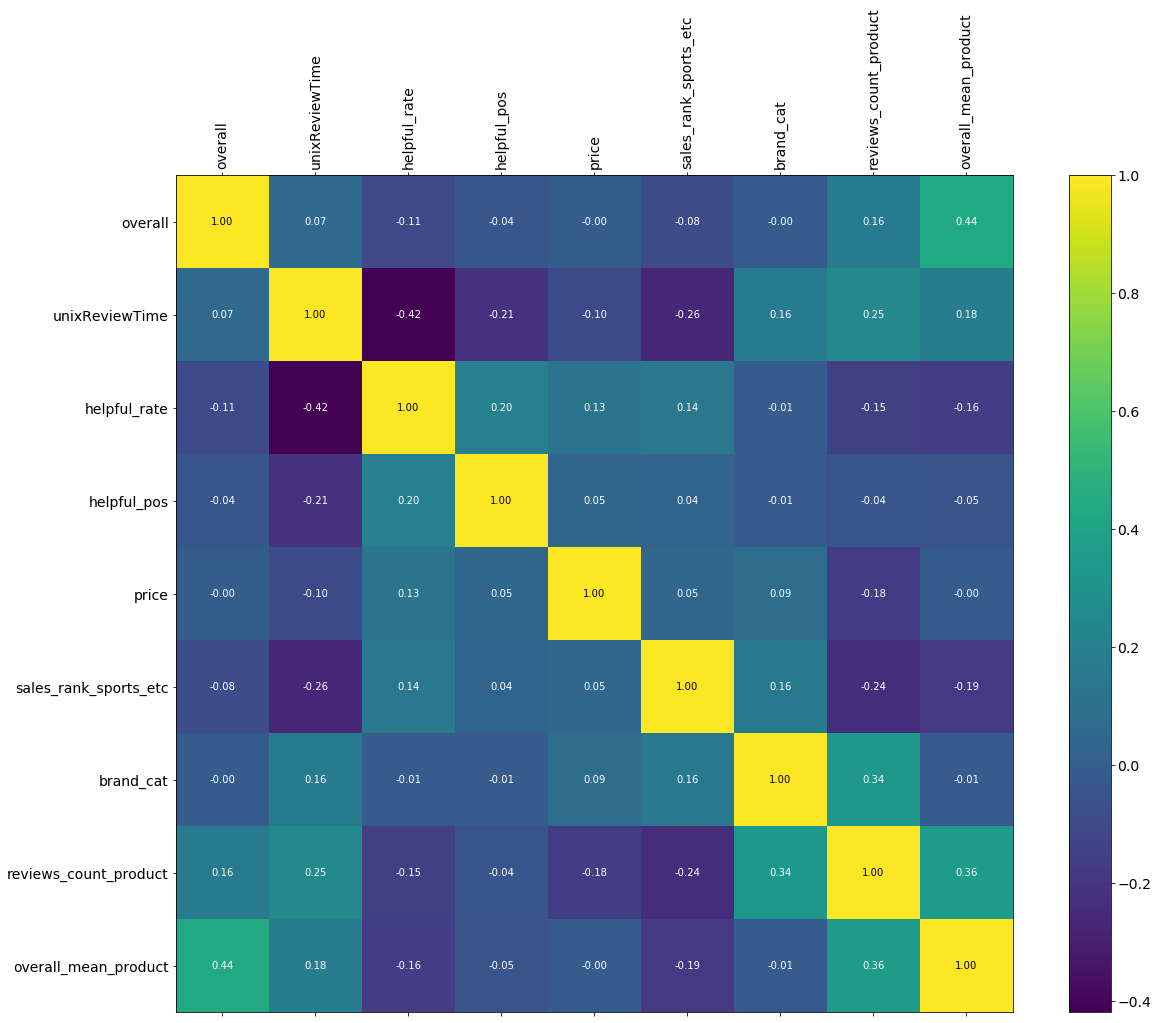

In [29]:
# Convert to Vector column type.
assembler = VectorAssembler(inputCols=df_result.columns, outputCol='corr')
df_vector = assembler.transform(df_result).select('corr')

labels = [label for label in df_result.columns]
num_labels = len(labels)

# Compute correlation matrix.
matrix = Correlation.corr(df_vector, 'corr')
# Format and shape correlation matrix.
corr_mat = matrix.collect()[0]["pearson({})".format('corr')].values.reshape(num_labels, num_labels)

f = plt.figure(figsize=(20, 15))
plt.matshow(corr_mat, fignum=f.number)

for y in range(corr_mat.shape[0]):
    for x in range(corr_mat.shape[1]):
        if x == y or corr_mat[y, x] > 0.7: color_text = 'k'
        else: color_text = 'w'
            
        plt.text(x, y, '%.2f' % corr_mat[y, x], \
                 horizontalalignment='center' , \
                 verticalalignment='center'   , \
                 color=color_text)

plt.xticks(range(num_labels), labels, fontsize=14, rotation=90)
plt.yticks(range(num_labels), labels, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()